In [2]:
import pandas as pd
import numpy as np
import matplotlib 
from matplotlib import pyplot as plt
from sklearn.neighbors import NearestNeighbors
!pip3 install gower umap
import gower
import umap

  Created wheel for gower: filename=gower-0.0.5-py3-none-any.whl size=4231 sha256=97af97f14d062700602d89c1e503dc086b7a8fbcea44eed7f31ac869fc48ff3b
  Stored in directory: /root/.cache/pip/wheels/3e/f9/9a/67122a959a424e9cbb4557a8366c871a30e31cd75f0d003db4
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3564 sha256=80ac9b0df085cb047dc5c29c80d0d73acb76b172c6a7286a7c60212c7871a3ce
  Stored in directory: /root/.cache/pip/wheels/65/55/85/945cfb3d67373767e4dc3e9629300a926edde52633df4f0efe
Successfully built gower umap


## Import data

In [4]:
df = pd.read_csv("sample_data/okcupid-cleaned-dropped-10k-handlabels.csv")
display(df)
print(df.columns)
df = df.drop(['sex', 'orientation', 'Unnamed: 0', 'hand-label'], axis=1)
df = df[:-1]

,Unnamed: 0,age,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,height,job,sign,smokes,arabic,chinese,english,german,hindi,italian,japanese,korean,portuguese,russian,spanish,turkish,has kids,wants kids,likes dogs,likes cats,new_religion,hand-label
0,30518.0,26.0,f,straight,5.0,vegan,2.0,sometimes,graduated from college/university,white,62.0,artistic / musical / writer,whatever,no,no,no,yes,no,no,no,no,no,no,no,yes,no,no,yes,yes,yes,agnosticism,T
1,56256.0,38.0,f,straight,5.0,anything,2.0,never,working on grad,white,69.0,science / tech / engineering,whatever,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,no,yes,no,none,NaN
2,31846.0,38.0,m,straight,5.0,anything,3.0,never,graduated from college/university,white,68.0,science / tech / engineering,whatever,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,no,no,no,none,NaN
3,38659.0,38.0,f,straight,4.0,anything,0.0,never,graduated from college/university,asian,63.0,other,whatever,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,no,no,no,catholicism,NaN
4,20309.0,24.0,f,gay,4.0,anything,2.0,sometimes,graduated from high school,white,68.0,retired,does_not_matter,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,no,no,no,other,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,32132.0,22.0,f,bisexual,5.0,vegetarian,2.0,sometimes,graduated from college/university,black,69.0,hospitality / travel,whatever,yes,no,no,yes,no,no,no,no,no,no,no,no,no,no,no,yes,no,none,NaN
9997,8119.0,22.0,m,straight,5.0,anything,2.0,sometimes,working on college/university,white,72.0,law / legal services,does_not_matter,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,no,yes,yes,agnosticism,NaN
9998,7887.0,20.0,f,straight,2.0,other,1.0,never,working on college/university,mixed,71.0,sales / marketing / biz dev,does_not_matter,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,yes,yes,no,christianity,NaN
9999,13868.0,27.0,f,straight,2.0,anything,2.0,never,graduated from college/university,white,67.0,other,whatever,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,no,yes,no,none,NaN


Index(['Unnamed: 0', 'age', 'sex', 'orientation', 'body_type', 'diet',
       'drinks', 'drugs', 'education', 'ethnicity', 'height', 'job', 'sign',
       'smokes', 'arabic', 'chinese', 'english', 'german', 'hindi', 'italian',
       'japanese', 'korean', 'portuguese', 'russian', 'spanish', 'turkish',
       'has kids', 'wants kids', 'likes dogs', 'likes cats', 'new_religion',
       'hand-label'],
      dtype='object')


## Unweighted KNN, K = 200

In [5]:
# Calculate the gower distance matrix and fit
import time

start_time = time.time()

unw_dist_matrix = gower.gower_matrix(df)
neigh = NearestNeighbors(n_neighbors=200, metric="precomputed")
neigh.fit(unw_dist_matrix)

unw_neighbor_matrix = neigh.kneighbors_graph(mode="distance")
print("--- %s seconds ---" % (time.time() - start_time))

--- 188.0272979736328 seconds ---


In [ ]:
neigh = NearestNeighbors(n_neighbors=200, metric="precomputed")
neigh.fit(unw_dist_matrix)

unw_neighbor_matrix = neigh.kneighbors_graph(mode="distance")
print(unw_neighbor_matrix)

  (0, 3922)	0.07927171
  (0, 1694)	0.08228885
  (0, 5486)	0.09667901
  (0, 7781)	0.09891041
  (0, 4069)	0.103957176
  (0, 3188)	0.10835351
  (0, 8405)	0.10994398
  (0, 2323)	0.11329108
  (0, 30)	0.11395575
  (0, 2209)	0.1174073
  (0, 7103)	0.11777762
  (0, 3240)	0.11806248
  (0, 3974)	0.1184779
  (0, 5310)	0.11871291
  (0, 4753)	0.119083226
  (0, 6870)	0.11941319
  (0, 5367)	0.120433934
  (0, 784)	0.12191995
  (0, 5738)	0.12220482
  (0, 2732)	0.123045154
  (0, 4267)	0.124540664
  (0, 1653)	0.12584627
  (0, 7732)	0.12641598
  (0, 5707)	0.1268409
  (0, 9955)	0.12827708
  :	:
  (9999, 7716)	0.085099466
  (9999, 2438)	0.08519916
  (9999, 687)	0.08528937
  (9999, 4994)	0.0858947
  (9999, 417)	0.08602526
  (9999, 1074)	0.08617006
  (9999, 9031)	0.08621516
  (9999, 717)	0.08631961
  (9999, 2023)	0.08631961
  (9999, 4731)	0.08668993
  (9999, 698)	0.08673978
  (9999, 1673)	0.08692494
  (9999, 6796)	0.08701989
  (9999, 5170)	0.08711485
  (9999, 391)	0.08711485
  (9999, 7340)	0.08729526
  (9999, 

### Visualizing performance

In [ ]:
NN = []
for i in range(unw_neighbor_matrix.shape[0]):
  NN.append(np.nonzero(unw_neighbor_matrix[i]))

df_unw = df.copy()
df_unw['NN'] = NN

#Preprocessing numerical
num = ['age', 'body_type', 'drinks', 'height']
numerical = df_unw[num]

##preprocessing categorical
categorical = df_unw.select_dtypes(include='object').drop(columns='NN')
categorical = pd.get_dummies(categorical)

#Percentage of columns which are categorical is used as weight parameter in embeddings later
categorical_weight = len(df_unw.select_dtypes(include='object').columns) / df.shape[1]

#Embedding numerical & categorical
fit1 = umap.UMAP(metric='l2', random_state=42).fit(numerical)
fit2 = umap.UMAP(metric='dice', random_state=42).fit(categorical)

#Augmenting the numerical embedding with categorical
intersection = umap.umap_.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = umap.umap_.reset_local_connectivity(intersection)
embedding = umap.umap_.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                fit1._initial_alpha, fit1._a, fit1._b, 
                                                fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                200, 'random', np.random.RandomState(seed=42), fit1.metric, 
                                                fit1._metric_kwds, False, fit1._densmap_kwds, fit1.output_dens)

x = embedding[0][:, 0]
y = embedding[0][:, 1]

/Users/anjalivyas/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


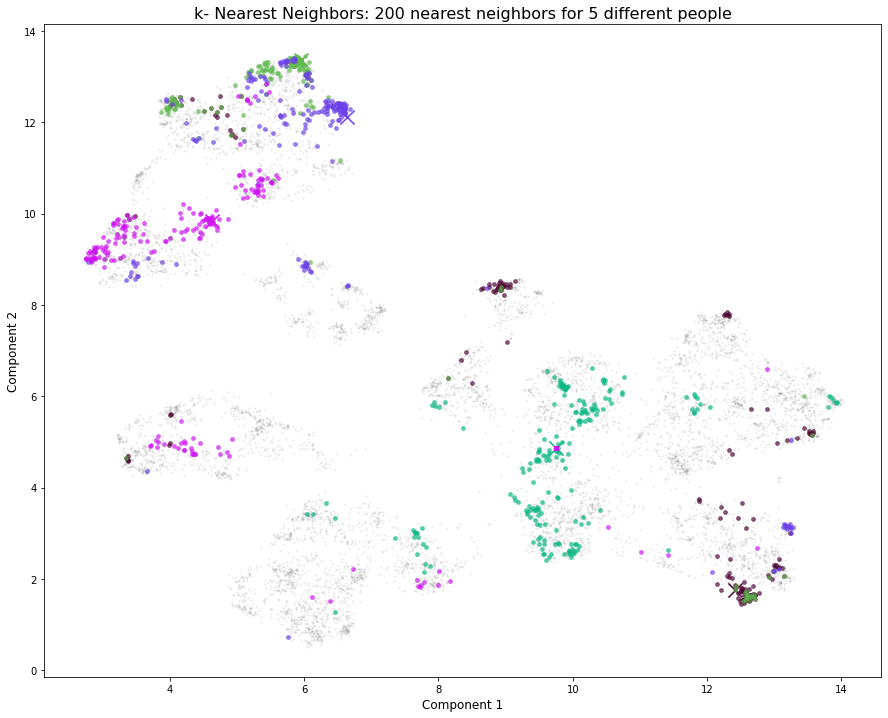

In [ ]:
import random

rand_colors = []

for j in range(5):
    rand_colors.append("#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)]))
    
plt.figure(figsize=(15, 12))
plt.scatter(x, y, s=2, alpha=0.1, c='grey')

for i in range(5):
  plt.scatter(x[i], y[i], s=200, c=rand_colors[i], marker='x')
  plt.scatter(np.take(x, [df_unw['NN'][i]]), np.take(y, [df_unw['NN'][i]]), s=14, c=rand_colors[i], alpha=0.6)

plt.xlabel('Component 1', size=12)
plt.ylabel('Component 2', size=12)
plt.title('k- Nearest Neighbors: 200 nearest neighbors for 5 different people', size=16)
plt.show()

### Evaluating performance with handlabeled data

#### Define function

In [ ]:
############################################################################################
# 
# Inputs
#
# neighbor_matrix --> a numpy matrix with dimensions n x n where n is the number of peeps
# neighbor_matrix[i][j] = 1 if the person at index j is a neighbor of the person at index i
#
# hand_label_info --> the dataframe version of 'okcupid-cleaned-dropped-10k-handlabels.csv'
#
# ==========================================================================================
# 
# Outputs (in order)
#
# sim_count --> the number of pairs (out of 50) which are correctly 
# assigned to the same cluster
# 
# dissim_count --> the number of pairs (out of 51) which are correctly
# assigned to different clusters
#
############################################################################################


def eval_neighbors_performance(neighbor_matrix, hand_label_info):
    
    # add the row number to each row of the hand_label_info df
    hand_label_info['index'] = range(0, len(hand_label_info))
    
    # get all 202 rows that have labels
    labeled_rows = hand_label_info[~hand_label_info['hand-label'].isnull()]
    
    # get all 100 rows with similar pairs of people
    sim = labeled_rows[labeled_rows['hand-label'].str.isnumeric()]
    
    # get all 102 rows with dissimilar pairs of people
    dissim = labeled_rows[~labeled_rows['hand-label'].str.isnumeric()]
    
    # sort both so similar / dissimilar pairs are consecutive
    sim = sim.sort_values(by=['hand-label'])
    dissim = dissim.sort_values(by=['hand-label'])
    
    # count the number of similar people who ended up in the same cluster
    
    # loop through every pair of similar people
    
    i = 0
    sim_count = 0
    
    while i + 1 < len(sim):
        
        person1 = sim.iloc[i]
        person2 = sim.iloc[i+1]
        
        # get the (original) row number associated with each person
        index1 = person1['index']
        index2 = person2['index']
        
        # increment the count if the two people's cluster assignments are the same
        if neighbor_matrix[index1][index2] != 0:
            sim_count += 1
        
        # move to the next pair
        i += 2
 
    
    # count the number of dissimilar people who ended up in different clusters
    
    # loop through every pair of dissimilar people
    
    j = 0
    dissim_count = 0
    
    while j + 1 < len(dissim):
        
        person1 = dissim.iloc[j]
        person2 = dissim.iloc[j+1]
        
        # get the (original) row number associated with each person
        index1 = person1['index']
        index2 = person2['index']
        
        # increment the count if the two people's cluster assignments are different
        if neighbor_matrix[index1,index2] == 0:
            dissim_count += 1
        
        # move to the next pair
        j += 2
        
    # print the performance 
    print(str(sim_count) + " out of 50 or " + str(round((sim_count/50)*100, 2)) + "% of similar pairs were in the same cluster")
    print(str(dissim_count) + " out of 51 or " + str(round((dissim_count/51)*100, 2)) + "% of dissimilar pairs were in different clusters")
    
    return sim_count, dissim_count

#### Evaluate

In [ ]:
hand_label_info = pd.read_csv('okcupid-cleaned-dropped-10k-handlabels.csv')
eval_neighbors_performance(unw_neighbor_matrix.toarray(), hand_label_info)

33 out of 50 or 66.0% of similar pairs were in the same cluster
51 out of 51 or 100.0% of dissimilar pairs were in different clusters


(33, 51)

## Weighted KNN, K = 200

In [ ]:
print(df.columns)

Index(['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'ethnicity',
       'height', 'job', 'sign', 'smokes', 'arabic', 'chinese', 'english',
       'german', 'hindi', 'italian', 'japanese', 'korean', 'portuguese',
       'russian', 'spanish', 'turkish', 'has kids', 'wants kids', 'likes dogs',
       'likes cats', 'new_religion'],
      dtype='object')


In [ ]:
# Calculate the gower distance matrix
feature_weights = np.array([4,3,2,3,4,4,3,3,2,1,4,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,2])
cat_features = [False, False, True, False, True, True, True, False, True, True, True, True, True,True, True, True, True, True,True, True, True, True, True,True, True, True, True, True]
w_dist_matrix = gower.gower_matrix(df, weight = feature_weights, cat_features = cat_features)
print(w_dist_matrix)
print(np.shape(w_dist_matrix))

[[0.         0.29273626 0.28730434 ... 0.19062892 0.3292556  0.25461048]
 [0.29273626 0.         0.09217889 ... 0.20972824 0.2519694  0.10559566]
 [0.28730434 0.09217889 0.         ... 0.25371435 0.2959555  0.10016377]
 ...
 [0.19062892 0.20972824 0.25371435 ... 0.         0.26033387 0.22224571]
 [0.3292556  0.2519694  0.2959555  ... 0.26033387 0.         0.22111337]
 [0.25461048 0.10559566 0.10016377 ... 0.22224571 0.22111337 0.        ]]
(10000, 10000)


In [ ]:
neigh = NearestNeighbors(n_neighbors=200, metric="precomputed")
neigh.fit(w_dist_matrix)

w_neighbor_matrix = neigh.kneighbors_graph(mode="distance")
print(w_neighbor_matrix)

  (0, 3922)	0.056366645
  (0, 1694)	0.07264952
  (0, 3188)	0.073514394
  (0, 5486)	0.07421991
  (0, 4069)	0.085838065
  (0, 7781)	0.08805391
  (0, 2323)	0.09079588
  (0, 4267)	0.09131401
  (0, 30)	0.09312224
  (0, 2209)	0.0949617
  (0, 7551)	0.09518833
  (0, 3974)	0.09840759
  (0, 7573)	0.09963443
  (0, 8405)	0.10016537
  (0, 2732)	0.101139955
  (0, 1129)	0.10161884
  (0, 6780)	0.10293377
  (0, 9427)	0.105626896
  (0, 5707)	0.10569016
  (0, 7654)	0.10623951
  (0, 5310)	0.10856747
  (0, 7887)	0.11007299
  (0, 1739)	0.110539064
  (0, 4753)	0.1110684
  (0, 5163)	0.11125739
  :	:
  (9999, 4520)	0.07152999
  (9999, 5185)	0.07180867
  (9999, 4934)	0.071810275
  (9999, 4616)	0.071862325
  (9999, 1021)	0.07204811
  (9999, 4965)	0.072049715
  (9999, 4328)	0.072049715
  (9999, 1110)	0.072049715
  (9999, 3300)	0.07209056
  (9999, 1668)	0.072289154
  (9999, 3994)	0.07238205
  (9999, 9396)	0.07238205
  (9999, 1380)	0.07242289
  (9999, 7889)	0.07242289
  (9999, 5134)	0.07256623
  (9999, 6099)	0.0726

### Visualizing performance

In [ ]:
NN = []
for i in range(w_neighbor_matrix.shape[0]):
  NN.append(np.nonzero(w_neighbor_matrix[i]))

df_w = df.copy()
df_w['NN'] = NN

#Preprocessing numerical
num = ['age', 'body_type', 'drinks', 'height']
numerical = df_w[num]

##preprocessing categorical
categorical = df_w.select_dtypes(include='object').drop(columns='NN')
categorical = pd.get_dummies(categorical)

#Percentage of columns which are categorical is used as weight parameter in embeddings later
categorical_weight = len(df_w.select_dtypes(include='object').columns) / df.shape[1]

#Embedding numerical & categorical
fit1 = umap.UMAP(metric='l2', random_state=42).fit(numerical)
fit2 = umap.UMAP(metric='dice', random_state=42).fit(categorical)

#Augmenting the numerical embedding with categorical
intersection = umap.umap_.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = umap.umap_.reset_local_connectivity(intersection)
embedding = umap.umap_.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                fit1._initial_alpha, fit1._a, fit1._b, 
                                                fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                200, 'random', np.random.RandomState(seed=42), fit1.metric, 
                                                fit1._metric_kwds, False, fit1._densmap_kwds, fit1.output_dens)

x = embedding[0][:, 0]
y = embedding[0][:, 1]

/Users/anjalivyas/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


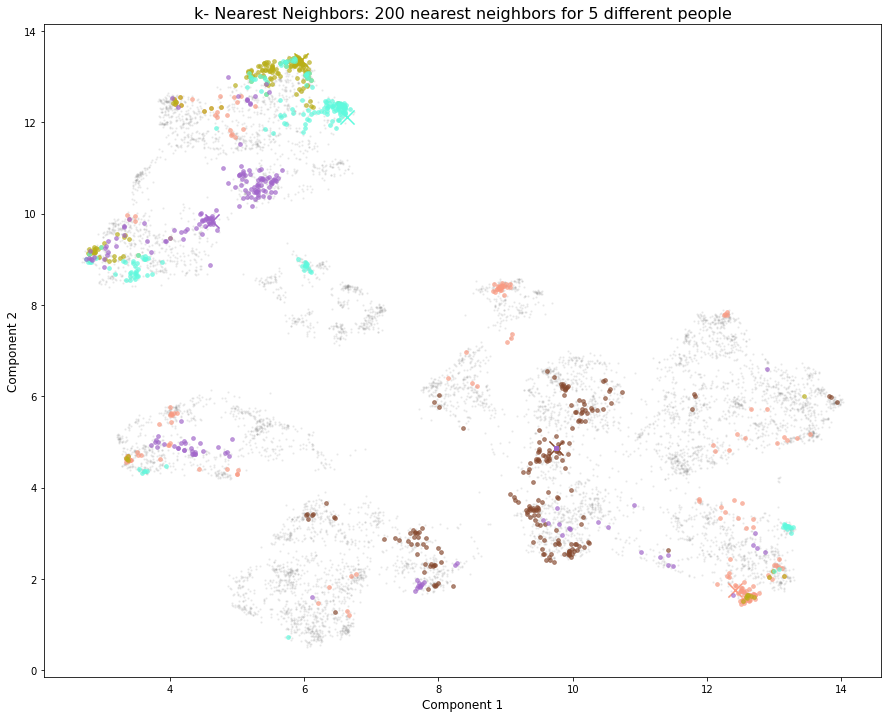

In [ ]:
import random

rand_colors = []

for j in range(5):
    rand_colors.append("#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)]))
    
plt.figure(figsize=(15, 12))
plt.scatter(x, y, s=2, alpha=0.1, c='grey')

for i in range(5):
  plt.scatter(x[i], y[i], s=200, c=rand_colors[i], marker='x')
  plt.scatter(np.take(x, [df_w['NN'][i]]), np.take(y, [df_w['NN'][i]]), s=14, c=rand_colors[i], alpha=0.6)

plt.xlabel('Component 1', size=12)
plt.ylabel('Component 2', size=12)
plt.title('k- Nearest Neighbors: 200 nearest neighbors for 5 different people', size=16)
plt.show()

### Evaluating performance with handlabeled data

In [ ]:
eval_neighbors_performance(w_neighbor_matrix.toarray(), hand_label_info)

38 out of 50 or 76.0% of similar pairs were in the same cluster
51 out of 51 or 100.0% of dissimilar pairs were in different clusters


(38, 51)